## Entity Recognition

In [1]:
import numpy as np
import pandas as pd
import datetime
import requests, json, re
import spacy
from spacy.util import minibatch, compounding
from pathlib import Path
import random
import matplotlib.pyplot as plt

## Load Data

In [2]:
tweets = []
with open('./tweets.json', 'r') as f:
    for line in f.readlines():
        tweets.append(json.loads(line))
print('There are', len(tweets),'tweets for topic clustering.')
print('Here is an example of the tweet:')
print(tweets[0])

There are 5071 tweets for topic clustering.
Here is an example of the tweet:
{'url': 'https://twitter.com/AshleyDHeck1/status/1244776214222553088', 'text': 'Ya know how everyone kept saying "hold my beer", as a way to show things could most definitely get worse in situations? ... Well they named this stupid virus after a beer. 🤦🍷🍷🤷😂 #randomthoughts #coronavirus #wth #COVID19 #corona #lol #imlosingit https://t.co/gZJIKJc8md', 'date': 1585612750000, 'tweet_id': 1244776214222553088, 'user_name': 'AshleyDHeck1', 'cleaned_text': 'Ya know how everyone kept saying hold my beer as a way to show things could most definitely get worse in situations  Well they named this stupid virus after a beer  randomthoughts coronavirus wth COVID corona lol imlosingit '}


In [3]:
df = pd.DataFrame(tweets[0:])
df = df.iloc[: , 0:6]
df.columns =["url","text","date","tweet_id","user_name","cleaned_text"]
df['date']=df['date'].apply(lambda d: datetime.datetime.fromtimestamp(int(d)/1000).strftime('%Y-%m-%d'))
df.head()

,url,text,date,tweet_id,user_name,cleaned_text
0,https://twitter.com/AshleyDHeck1/status/124477...,"Ya know how everyone kept saying ""hold my beer...",2020-03-30,1244776214222553088,AshleyDHeck1,Ya know how everyone kept saying hold my beer ...
1,https://twitter.com/CffeeAndSarcasm/status/124...,AA is going to need a bouncer when this is ove...,2020-03-30,1244758836516397056,CffeeAndSarcasm,AA is going to need a bouncer when this is ove...
2,https://twitter.com/KarinBrauns/status/1244757...,Don’t drown in your own thoughts.. Stay close ...,2020-03-30,1244757544431751171,KarinBrauns,Don’t drown in your own thoughts Stay close at...
3,https://twitter.com/AspenBrewingCo/status/1244...,Mix it up this week with a delicious pizza and...,2020-03-30,1244753120669958144,AspenBrewingCo,Mix it up this week with a delicious pizza and...
4,https://twitter.com/Didanmeg/status/1244748406...,The only beer we will be drinking until this w...,2020-03-30,1244748406435852289,Didanmeg,The only beer we will be drinking until this w...


## IBM Watson NLU

In [4]:
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 import Features, EntitiesOptions

In [5]:
# eample useage
text = tweets[500]['cleaned_text']

authenticator = IAMAuthenticator('oTGzEC4oCKWRm0Z_V3cErezPKb_V_506O-Z3OsQPsEdo')
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2020-08-01',
    authenticator=authenticator
)

natural_language_understanding.set_service_url('https://api.us-south.natural-language-understanding.watson.cloud.ibm.com/instances/38c1029f-c8a5-4f16-bba8-0aa47c47b4bf')

response = natural_language_understanding.analyze(text= text, features=Features(
                entities=EntitiesOptions(emotion=True, sentiment=False,limit=10))).get_result()

print(json.dumps(response, indent=2))

{
  "usage": {
    "text_units": 1,
    "text_characters": 262,
    "features": 1
  },
  "language": "en",
  "entities": []
}


## Spacy

In [6]:
nlp = spacy.load("en_core_web_sm")

In [7]:
ents=[]
for i in range(0, len(tweets)):
    for ent in nlp(tweets[i]['cleaned_text']).ents:
        ents.append((ent.text, ent.start_char, ent.end_char, ent.label_))  
        
len(ents)

9718

In [8]:
ents[0:5]

[('COVID', 196, 201, 'ORG'),
 ('COVID', 78, 83, 'ORG'),
 ('Quarantine', 85, 95, 'PRODUCT'),
 ('QuarantineLife', 97, 111, 'ORG'),
 ('this week', 10, 19, 'DATE')]

In [9]:
df = pd.DataFrame(ents)
df.columns = ['text', 'start_char', 'end_char', 'Entity Label']
df.head() # can be improved

,text,start_char,end_char,Entity Label
0,COVID,196,201,ORG
1,COVID,78,83,ORG
2,Quarantine,85,95,PRODUCT
3,QuarantineLife,97,111,ORG
4,this week,10,19,DATE


In [10]:
df=df.drop(columns=['start_char', 'end_char'])
ent_count=df.groupby(['Entity Label']).count()
ent_count.columns = ['No of Ents']
ent_count=ent_count.sort_values(by=['No of Ents'])

<Figure size 7200x5760 with 0 Axes>

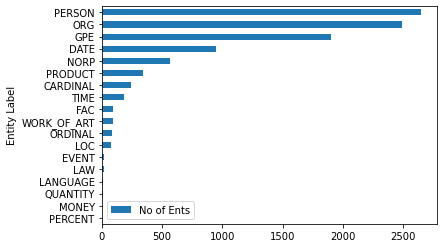

In [11]:
plt.figure(figsize=(100,80))
ent_count.plot.barh(stacked=True)
plt.savefig('ent_count.png')